In [1]:
from deepinv.physics.generator import DiffractionBlurGenerator
from src.utils.display_utils import show_images
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transform
from product_convolution import *

In [2]:
device = 'cuda'
dtype = torch.float32
torch.set_default_device(device)
torch.set_default_dtype(dtype)

## Plot utils

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
from torch import Tensor
import numpy as np
from typing import List, Optional, Tuple, Union
import warnings
warnings.filterwarnings("ignore", module="matplotlib\..*")

_TensorArray = Union[Tensor, np.ndarray]

def to_numpy_image(input):
    if isinstance(input, Tensor):
        if input.dim() == 3:
            return input.detach().cpu().permute(1, 2, 0).numpy()
        elif input.dim() == 4:
            return input.detach().cpu().permute(0, 2, 3, 1).numpy()

    elif isinstance(input, np.ndarray):
        print("Warning: input is already a numpy array")
        return input
    else:
        raise ValueError(f"Cannot convert {type(input)} to numpy image")
def show_images(
    imgs: Union[_TensorArray, List[_TensorArray], Tuple[_TensorArray]],
    title: List[str] = None,
    suptitle: str = None,
    ncols: int = None,
    colorbar: Optional[bool] = False,
    cmap: str = None,
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    savename: Optional[str] = None,
    figsize: Optional[int] = 3,
    interpolation: Optional[str] = None,
):

    if isinstance(imgs, List) or isinstance(imgs, Tuple):
        if isinstance(imgs[0], np.ndarray):
            imgs = np.concatenate(imgs, axis=0)
        elif isinstance(imgs[0], torch.Tensor):
            imgs = to_numpy_image(torch.cat(imgs, dim=0))
    else:
        imgs = to_numpy_image(imgs)

    if imgs.ndim == 3:
        H, W, C = imgs.shape
        B = 1
    elif imgs.ndim == 4:
        B, H, W, C = imgs.shape

    if (ncols is not None) and (B % ncols == 0):
        nrows = B // ncols
    else:
        nrows = 1
        ncols = B
    offset = 0 if not colorbar else 0.75
    fig = plt.figure(figsize=(ncols * (figsize + offset), nrows * figsize))
    gs = gridspec.GridSpec(ncols=ncols, nrows=nrows)
    gs.update(wspace=0.025, hspace=0.025)

    if cmap is None:
        cmap = "gray" if C == 1 else None
    i = 0

    if title is None:
        title = [""]
    if len(title) != B:
        title += [""] * (B - len(title))
    with warnings.catch_warnings():
        if nrows > 1 and ncols > 1:
            for r in range(nrows):
                for c in range(ncols):
                    axs = plt.subplot(gs[r, c])
                    im = axs.imshow(
                        imgs[i],
                        vmin=vmin,
                        vmax=vmax,
                        cmap=cmap,
                        interpolation=interpolation,
                    )
                    axs.set_xticks([])
                    axs.set_yticks([])
                    if colorbar:
                        divider = make_axes_locatable(axs)
                        cax = divider.append_axes("right", size="3%", pad=0.1)
                        plt.colorbar(im, cax=cax)
                    if title:
                        axs.set_title(title[i], pad=3)

                    i += 1
        elif nrows > 1 or ncols > 1:
            for c in range(max(ncols, nrows)):
                axs = plt.subplot(gs[c])
                im = axs.imshow(
                    imgs[c], vmin=vmin, vmax=vmax, cmap=cmap, interpolation=interpolation
                )
                axs.set_xticks([])
                axs.set_yticks([])
                if colorbar:
                    divider = make_axes_locatable(axs)
                    cax = divider.append_axes("right", size="3%", pad=0.1)
                    plt.colorbar(im, cax=cax)
                if title:
                    axs.set_title(title[c], pad=3)

        else:
            axs = plt.subplot(gs[0])
            im = axs.imshow(
                imgs.squeeze(), vmin=vmin, vmax=vmax, cmap=cmap, interpolation=interpolation
            )
            axs.set_xticks([])
            axs.set_yticks([])
            if colorbar:
                divider = make_axes_locatable(axs)
                cax = divider.append_axes("right", size="3%", pad=0.1)
                plt.colorbar(im, cax=cax)
            if title:
                axs.set_title(title[0], pad=3)

        if suptitle is not None:
            fig.suptitle(suptitle, y=1.03)
        if savename is not None:
            fig.savefig(savename, bbox_inches='tight')
            plt.close()
        else:
            plt.show()

## Test on image


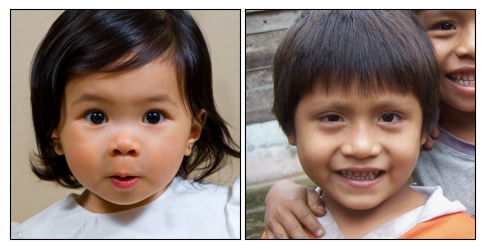

In [4]:
# %% TEST PRODUCT-CONVOLUTION
path_1 = '/home/minhhai/Works/datasets/FFHQ/images1024x1024/00003.png'
path_2 = '/home/minhhai/Works/datasets/FFHQ/images1024x1024/00014.png'

image_1 = Image.open(path_1)
image_1 = transform.ToTensor()(image_1)

image_2 = Image.open(path_2)
image_2 = transform.ToTensor()(image_2)

image = torch.stack([image_1, image_2], dim=0).cuda()
show_images(image)

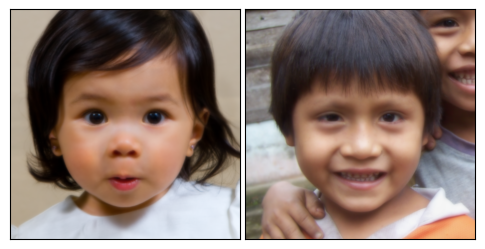

In [5]:
psf_size = (31, 31)
patch_size = (256, 256)
overlap = (128, 128)
image_size = (1024, 1024)
patches = image_to_patches(image, patch_size=patch_size, overlap=overlap)
patch_info = compute_patch_info(image_size, patch_size, overlap)
K = patches.size(2) * patches.size(3)


generator = DiffractionBlurGenerator(
    psf_size, num_channels=3, device=device, dtype=dtype)
h = torch.stack([generator.step(image.size(0))['filter']
                 for _ in range(K)], dim=2)

masks = unity_partition_function_2d(image.shape[-2:], patch_size, overlap)
w, _ = crop_unity_partition_2d(masks, patch_size, overlap, psf_size)
w = w.flatten(0,1).unsqueeze(0).unsqueeze(0)

# show_images(h.transpose(2,1).flatten(0, 1) ** 0.25, ncols=K)
blurry = product_convolution2d_patches(image, w, h, patch_size, overlap)
show_images(blurry)

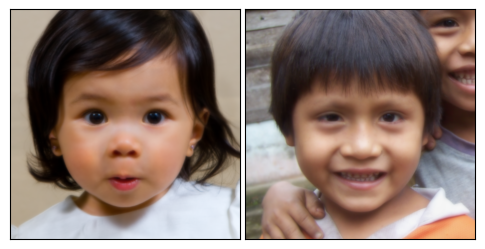

In [6]:
import deepinv as dinv
physic = dinv.physics.SpaceVaryingBlur(filters=h, multipliers=w, padding='valid', method='product_convolution2d_patch', patch_size=patch_size, overlap=overlap, device='cuda')
blurry = physic.A(image)
show_images(blurry)

## TEST GET-PSF

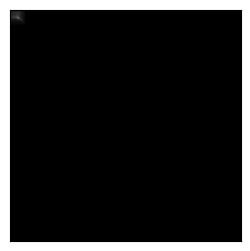

In [7]:
psf_size = (31, 31)
patch_size = (128, 128)
overlap = (64, 64)
image_size = (512, 512)
dirac = torch.zeros((1,3) + image_size)
dirac[...,30,30] = 1.
patches = image_to_patches(dirac, patch_size, overlap)
patch_info = compute_patch_info(image_size, patch_size, overlap)
K = patches.size(2) * patches.size(3)


generator = DiffractionBlurGenerator(
    psf_size, num_channels=3, fc=0.2, device=device, dtype=dtype)
h = torch.stack([generator.step(dirac.size(0))['filter']
                 for _ in range(K)], dim=2)

masks = unity_partition_function_2d(dirac.shape[-2:], patch_size, overlap)
w, _ = crop_unity_partition_2d(masks, patch_size, overlap, psf_size)
w = w.flatten(0,1).unsqueeze(0).unsqueeze(0)

# show_images(h.transpose(2,1).flatten(0, 1) ** 0.25, ncols=K)
blurry = product_convolution2d_patches(dirac, w, h, patch_size, overlap)
show_images(blurry ** 0.25)

### Simple loops

In [ ]:
patch_size = (128, 128)
overlap = (40, 40)
max_size = 215
for i in range(max_size):
    for j in range(max_size):
        image = torch.zeros(2, 3, 256, 256)
        position = (i, j)
        
        out = get_index_and_position(position,  patch_size, overlap, num_patches = physic.num_patches)
        out_2 = get_index_and_position_2(position,  patch_size, overlap, num_patches = physic.num_patches)

        if out != out_2:
            print(f'---------------{position}-----------------') 
            print(out)
            print(out_2)

    

In [9]:
import deepinv as dinv 
from deepinv.physics.generator import DiffractionBlurGenerator, ProductConvolutionPatchBlurGenerator

psf_size = (31, 31)
patch_size = (128, 128)
overlap = (40, 40)
image_size = 256
image = torch.zeros(2, 3, image_size, image_size, device=device)

diffraction_generator = DiffractionBlurGenerator(psf_size,  device=device)
generator = ProductConvolutionPatchBlurGenerator(psf_generator=diffraction_generator,
                                                    image_size=image_size,
                                                    patch_size=patch_size,
                                                    overlap=overlap,
                                                    device=device)
params = generator.step(2)
h = params['filters']
w = params['multipliers']

physic = dinv.physics.SpaceVaryingBlur(filters=h, multipliers=w, padding='valid', method='product_convolution2d_patch', patch_size=patch_size, overlap=overlap, device='cuda')

max_size = 150
for i in range(psf_size[0], max_size):
    for j in range(psf_size[1], max_size):
        image = torch.zeros(2, 3, 256, 256)
        position = (i, j)
        image[..., position[0]: position[0] + 1, position[1]: position[1] + 1] = 1.
        blurry = physic.A(image)
        psf_pc = blurry[:,0:1, 
                        position[0] - psf_size[0] + 1: position[0] + 1, 
                        position[1] - psf_size[1] + 1: position[1] + 1]

        psf_hat = physic.get_psf(position).flatten(0,1)
        diff = psf_pc - psf_hat
        if torch.norm(diff) > 1e-5:
            print(f'{i, j}: ', torch.norm(diff))
            show_images([psf_pc, psf_hat, psf_pc - psf_hat])
            break

### Optimized version

In [4]:
def generate_random_patch(tensor: Tensor, centers: Tensor, patch_size: tuple[int]):
    """
    Args:
        tensor (Tensor): Tensor of patch_size (B, C, H, W) to be cropped.
        centers (Tensor): (B, num_patches, 2)
    Returns:
        Tensor: Randomly cropped Tensor of shape (B, C, num_patches, patch_size, patch_size)
    """
    device = tensor.device

    if isinstance(patch_size, int):
        patch_size = (patch_size, patch_size)

    patch_size_h, patch_size_w = patch_size

    i, j = centers[..., 0:1],  centers[..., 1:2]

    # B, num_patches, patch_size
    rows = torch.arange(-patch_size_h//2 + patch_size_h % 2, patch_size_h//2 + patch_size_h % 2, dtype=torch.long, device=device) + i
    columns = torch.arange(-patch_size_w//2 + patch_size_w % 2, patch_size_w//2 + patch_size_w % 2, dtype=torch.long, device=device) + j

    patches = tensor[torch.arange(tensor.size(0), device=tensor.device, dtype=torch.long)[:, None, None, None],
                      :, 
                    rows[..., None],
                    columns[...,None, :]]

    return patches.permute(0, -1, 1, 2, 3)

h torch.Size([2, 1, 7, 7, 41, 41])
w torch.Size([1, 1, 7, 7, 256, 256])
index_h torch.Size([2, 10, 2])
index_w torch.Size([2, 10, 2])
patch_position_h torch.Size([2, 10, 2])
patch_position_w torch.Size([2, 10, 2])
0


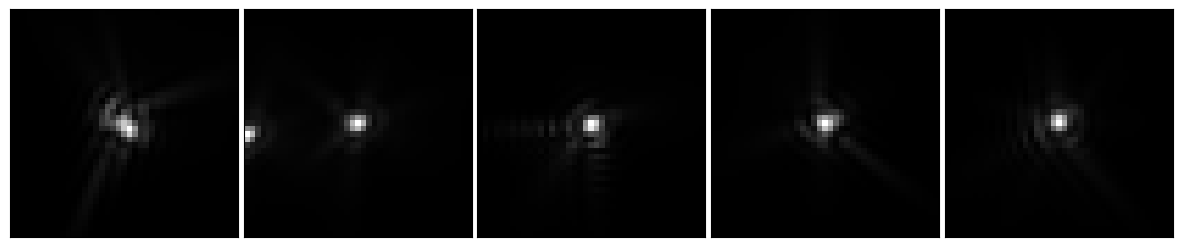

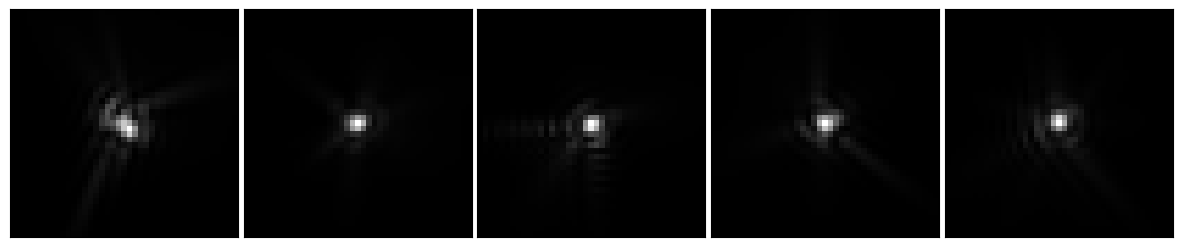

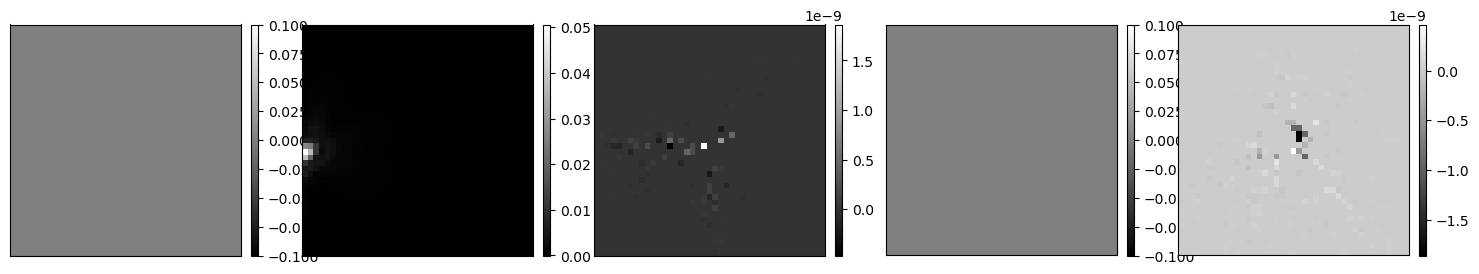

In [5]:
import deepinv as dinv 
from deepinv.physics.generator import DiffractionBlurGenerator, ProductConvolutionPatchBlurGenerator
import torch.nn.functional as F 
from product_convolution import image_to_patches
from torchvision.transforms.functional import center_crop

psf_size = (41, 41)
patch_size = (256, 256)
overlap = (128, 128)
stride = (patch_size[0] - overlap[0], patch_size[1] - overlap[1])
image_size = 1024
device='cuda'

diffraction_generator = DiffractionBlurGenerator(psf_size,  device=device)
generator = ProductConvolutionPatchBlurGenerator(psf_generator=diffraction_generator,
                                                    image_size=image_size,
                                                    patch_size=patch_size,
                                                    overlap=overlap,
                                                    device=device)
params = generator.step(2)
h = params['filters']
w = params['multipliers']

physic = dinv.physics.SpaceVaryingBlur(filters=h, multipliers=w, padding='valid', method='product_convolution2d_patch', patch_size=patch_size, overlap=overlap, device='cuda')

random_patch = True
# image = torch.zeros(2, 3, image_size, image_size, device=device)
# image[...,patch_size[0] // 2::stride[0], patch_size[1] // 2::stride[1]] = 1.
for it in range(100):
    if random_patch:       
        centers = torch.randint(patch_size[0] // 2, image_size - patch_size[0] // 2, size=(2, 10, 2), device='cuda')
    else:
        row = torch.arange(
            patch_size[0] // 2, image_size - patch_size[0] // 2, patch_size[0] - overlap[0], device=device)
        col = torch.arange(
            patch_size[1] // 2, image_size - patch_size[1] // 2, patch_size[1] - overlap[1], device=device)

        row, col = torch.meshgrid(row, col, indexing='ij')
        centers = torch.stack((row.flatten(),
                                col.flatten()), dim=1).unsqueeze(0) #.expand(2, -1, -1)
    
    image = torch.zeros(2, 3, image_size, image_size, device=device)

    image[torch.arange(2)[:,None],
          :,
          centers[...,0],
          centers[...,1],
        ] = 1.
    
    
    blurry = physic.A(image)
    blurry_padded = F.pad(blurry, (psf_size[1] // 2, psf_size[1] // 2, psf_size[0] // 2, psf_size[0] // 2), mode='constant', value=0)

    psf_pc = generate_random_patch(blurry_padded, centers=centers, patch_size=psf_size).transpose(1,2).flatten(0,1)[:,0:1]

    psf_hat = physic.get_psf_optimized(centers).transpose(1,2).flatten(0,1)[:,0:1]
    
    
    diff = psf_pc - psf_hat
    # print(torch.norm(diff))
    if torch.norm(diff) > 1e-5:
        print(it)
        show_images(psf_pc[:5])
        show_images(psf_hat[:5])
        show_images(psf_pc[:5] - psf_hat[:5], colorbar=True)
        break

    # if not random_patch:
    #     break

In [6]:
physic.get_psf_optimized(centers).shape

h torch.Size([2, 1, 7, 7, 41, 41])
w torch.Size([1, 1, 7, 7, 256, 256])
index_h torch.Size([2, 10, 2])
index_w torch.Size([2, 10, 2])
patch_position_h torch.Size([2, 10, 2])
patch_position_w torch.Size([2, 10, 2])


torch.Size([2, 1, 10, 41, 41])

In [7]:
centers.shape 

torch.Size([2, 10, 2])

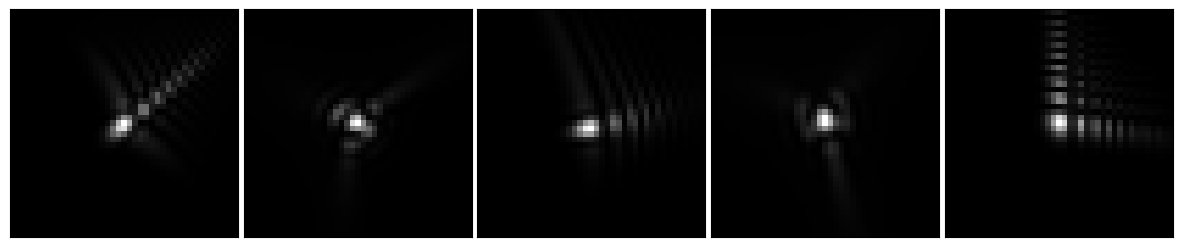

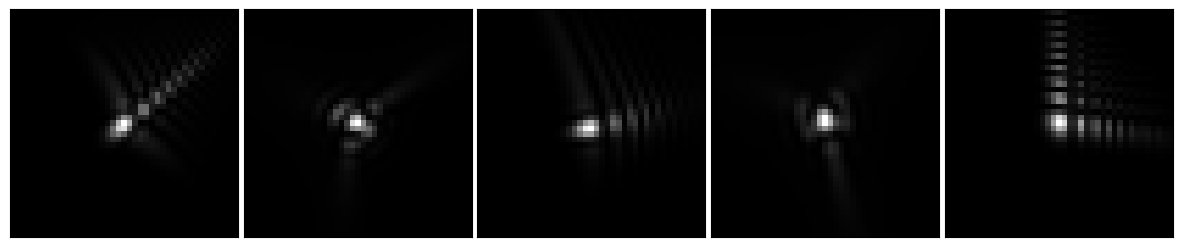

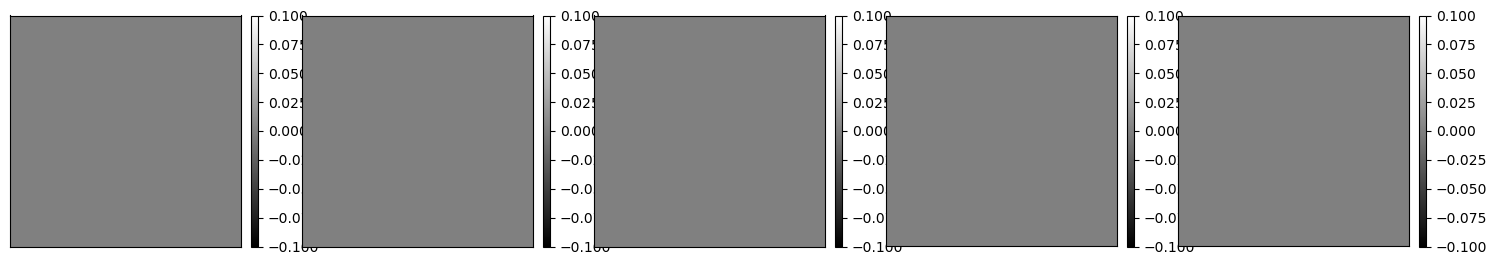

In [109]:
show_images(psf_pc[:5])
show_images(psf_hat[:5])
show_images(psf_pc[:5] - psf_hat[:5], colorbar=True)

## TEST ADJOINTNESS 

In [64]:
psf_size = (31, 31)
patch_size = (128, 128)
overlap = (64, 64)
stride = (patch_size[0] - overlap[0], patch_size[1] - overlap[1])
image_size = 512
device='cuda'

diffraction_generator = DiffractionBlurGenerator(psf_size,  device=device)
generator = ProductConvolutionPatchBlurGenerator(psf_generator=diffraction_generator,
                                                    image_size=image_size,
                                                    patch_size=patch_size,
                                                    overlap=overlap,
                                                    device=device)
params = generator.step(2)
h = params['filters']
w = params['multipliers']

physic = dinv.physics.SpaceVaryingBlur(filters=h, multipliers=w, padding='valid', method='product_convolution2d_patch', patch_size=patch_size, overlap=overlap, image_size=image_size, device='cuda')

x = torch.randn(2,3,image_size,image_size)
Ax = physic.A(x) 
y = torch.randn_like(Ax)
ATy = physic.A_adjoint(y)

left = (Ax * y).view(x.size(0), -1).sum(dim = 1)
right = (ATy * x).view(y.size(0), -1).sum(dim = 1)

print((left - right).abs())
assert torch.allclose(left, right, atol=1e-6), "Adjointness Test Failed"


tensor([6.1035e-05, 1.5259e-05], device='cuda:0')


## Time

In [65]:
from torch.utils.benchmark import Timer


In [70]:
image_size = 1024
patch_size = 256
overlap = 128
psf_size = 31

from deepinv.physics.generator import ProductConvolutionPatchBlurGenerator
from deepinv.physics import SpaceVaryingBlur

psf_generator = DiffractionBlurGenerator(
    (psf_size, psf_size), num_channels=3, fc=0.2, device=device, dtype=dtype)

pc_generator = ProductConvolutionPatchBlurGenerator(
    psf_generator=psf_generator,
    image_size=image_size,
    patch_size=patch_size,
    overlap=overlap,
    device=device
)
params_pc = pc_generator.step(1)
physics = SpaceVaryingBlur(method="product_convolution2d_patch",
                           patch_size= patch_size, 
                           overlap=overlap,
                           device=device,
                           image_size=image_size,
                            **params_pc, )
batch_size = 8
n_patch = 32
params = pc_generator.step(batch_size)
centers = torch.randint(patch_size //2, image_size - patch_size // 2, size = (batch_size, n_patch, 2))


In [79]:
psf_1 = physics.get_psf(centers, **params)
print(psf_1.shape)

torch.Size([8, 3, 32, 31, 31])


In [80]:
psf_2 = physics.get_psf_optimized(centers, **params)
print(psf_2.shape)

torch.Size([8, 3, 32, 31, 31])


In [81]:
print(torch.allclose(psf_1, psf_2))

True


In [85]:
timer = Timer(stmt='physics.get_psf(centers, **params)',
    globals=globals())
timer.blocked_autorange(min_run_time=5)

physics.get_psf(centers, **params)
  Median: 294.16 ms
  IQR:    13.96 ms (289.82 to 303.78)
  17 measurements, 1 runs per measurement, 1 thread

In [86]:
timer = Timer(stmt='physics.get_psf_optimized(centers, **params)',
    globals=globals())
timer.blocked_autorange(min_run_time=5)

physics.get_psf_optimized(centers, **params)
  Median: 15.64 ms
  IQR:    9.06 ms (7.50 to 16.56)
  38 measurements, 10 runs per measurement, 1 thread
           This suggests significant environmental influence.